In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import OneHotEncoder
import torch
import kagglehub

In [8]:
# Read in csv file
df = pd.read_csv(r"insurance.csv").sort_values("smoker", ascending = True)

df.head()

,age,sex,bmi,children,smoker,region,charges
556,46,male,33.440,1,no,northeast,8334.58960
724,50,female,27.075,1,no,northeast,10106.13425
1197,41,male,33.550,0,no,southeast,5699.83750
726,41,male,28.405,1,no,northwest,6664.68595
728,18,female,40.280,0,no,northeast,2217.60120


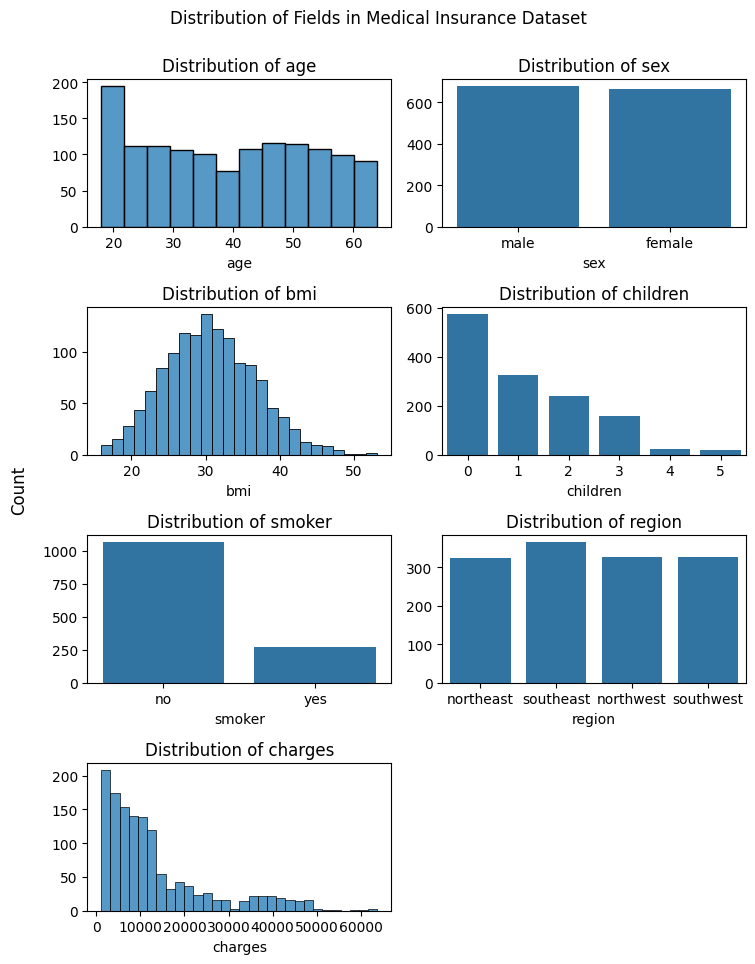

In [9]:
# First we do some EDA and see the distribution of the data

fig1, axes1 = plt.subplots(math.ceil(len(df.columns)/2), 2)

# Remove extra plot for odd number of columns
if len(df.columns)%2 == 1:
    fig1.delaxes(axes1[-1,-1])

fig1.suptitle("Distribution of Fields in Medical Insurance Dataset", y = 1)
fig1.supylabel("Count")

for i, field in enumerate(df.columns):

    # Histplot for wider range numerical values
    if field in ["age", "bmi", "charges"]:
        sns.histplot(x = field, data = df, ax = axes1[i//2,i%2])
    # Countplot for categorical data or numerical with only a few values
    else:
        sns.countplot(x = field, data = df, ax = axes1[i//2,i%2])

    axes1[i//2,i%2].set_title(f"Distribution of {field}")
    axes1[i//2,i%2].set_ylabel("")

fig1.set_figheight(fig1.get_figheight()*2)
fig1.set_figwidth(fig1.get_figwidth()*1.2)
fig1.tight_layout()
plt.show()

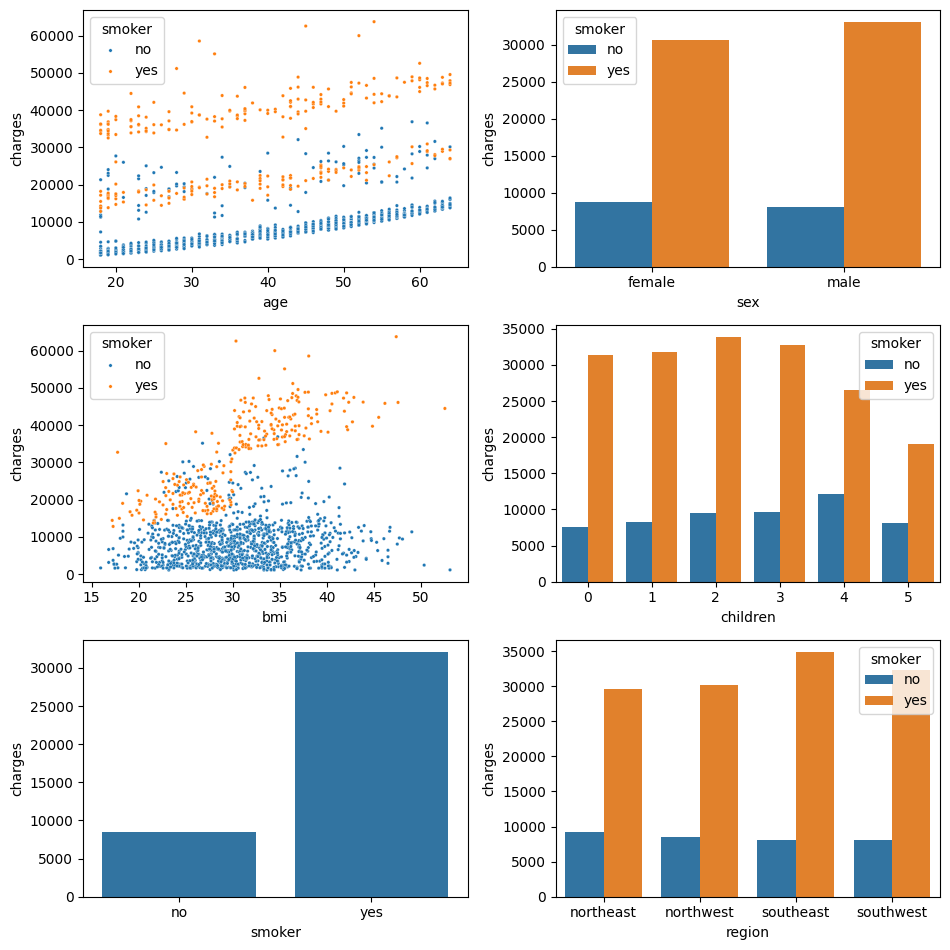

In [10]:
fig2, axes2 = plt.subplots(math.ceil((len(df.columns)-1)/2), 2)

# Remove extra plot for odd number of columns
if (len(df.columns)-1)%2 == 1:
    fig2.delaxes(axes2[-1,-1])

for i, field in enumerate(df.columns.drop(["charges"])):

    if field in ["age", "bmi"]:
        sns.scatterplot(x= field, y = "charges", data = df, ax = axes2[i//2, i%2], marker = "o", s = 6, hue = "smoker")
    
    elif field == "smoker":
        data = df.groupby(field)["charges"].mean().reset_index()
        sns.barplot(x = field, y = "charges", data = data, ax = axes2[i//2, i%2])
    else:
        data = df.groupby([field, "smoker"])["charges"].mean().reset_index()
        sns.barplot(x = field, y = "charges", data = data, ax = axes2[i//2, i%2], hue = "smoker")

fig2.set_figheight(fig2.get_figheight()*2)
fig2.set_figwidth(fig2.get_figwidth()*1.5)
fig2.tight_layout()
plt.show()

In [11]:
df["smoker"] = df["smoker"].apply(lambda x: x == "yes")
df["sex"] = df["sex"].apply(lambda x: x == "female")

# One-Hot encode the region variable
df = pd.get_dummies(df, columns = ["region"])

In [12]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
556,46,False,33.440,1,False,8334.58960,True,False,False,False
724,50,True,27.075,1,False,10106.13425,True,False,False,False
1197,41,False,33.550,0,False,5699.83750,False,False,True,False
726,41,False,28.405,1,False,6664.68595,False,True,False,False
728,18,True,40.280,0,False,2217.60120,True,False,False,False
